### 0. What we're going to cover

* Getting a custom dataset with PyTorch
* Becoming one with the data (preparing and visualising)
* Transforming data for use with a model
* Loading custom data with prebult functions and custom functions
* Building FoodVision Mini to classify (images)
* Comparing models with and wihtout data augmentation
* Making predictions on custom data

### 04 Pytorch custom data set

we'he used some datasets with PyTorch before.
But how do you get your own data into PyTorch?

One of the ways to do so is via : custom datasets.

## Domain libraries

Deepending on what you're working on, vision ,text  , audio , recommendation, you'll want to look each of the PyTorch domain libraries for existing data loading functions and customizing data loading functions.

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.8.0+cu126'

In [ ]:
# Setup the device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1. Get dataset

Our dataset is a subset of the Food101 dataset.

Food1010 Starts 1010 different classes of food and 1000 images per class (750 training , 220 testing )

Our dataset starts with 3 classes of food and only 10% of the images. (-75% training , and 25% testing )




In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Now Downloading the image if the image do not exists
if image_path.is_dir():
  print(f"{image_path} directory already exist. Skipping downloading...")
else:
  print(f"{image_path} do not exist creating one....")
  data_path.mkdir(parents=True , exist_ok=True)

# Download the pizza_steak_sushi dataset
with open(data_path / "pizza_steak_sushi.zip" , "wb") as f:
  response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(response.content)

# Now unziping the file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print(f"Unzipping the data..")
  zip_ref.extractall(image_path)



data/pizza_steak_sushi do not exist creating one....
Unzipping the data..


### 2 Becoming one with the data (data preparation and data exploration)


In [ ]:
from posixpath import dirname
import os
def wal_through_dir(dir_path):
  """Walk thorugh the dir_path returning its contents"""
  for dirpath , dirnames , filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in  {dirpath}")


In [ ]:
wal_through_dir(image_path)

There are 2 directories and 0 images in  data/pizza_steak_sushi
There are 3 directories and 0 images in  data/pizza_steak_sushi/test
There are 0 directories and 31 images in  data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in  data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in  data/pizza_steak_sushi/test/steak
There are 3 directories and 0 images in  data/pizza_steak_sushi/train
There are 0 directories and 72 images in  data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in  data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in  data/pizza_steak_sushi/train/steak


In [ ]:
# Setup the training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir , test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image
Lets write some code to :

1. Get all of the image paths
2. pick a random image path using PyTorch's random.choice()
3. Get the image class name sing `pathlib.Path.aprent.stem`
4. Since we're working with images , lets open the image with Python's PIL
5. We'll then show the image and print metadata


data/pizza_steak_sushi/train/pizza/3530210.jpg
pizza
Random image path : data/pizza_steak_sushi/train/pizza/3530210.jpg
Image class : pizza
Image height : 512
Image width : 512


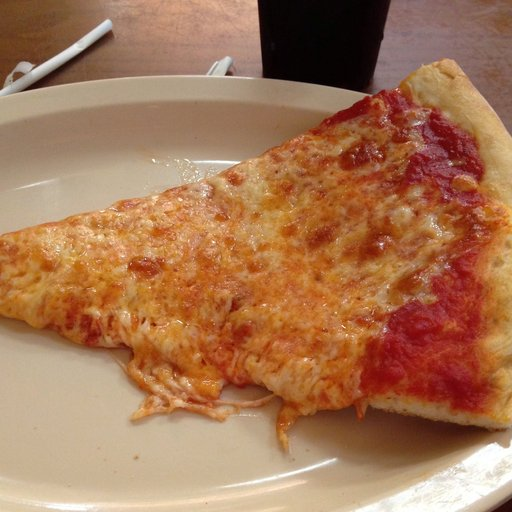

In [ ]:
import random
from PIL import Image
# Set seed
# random.seed(42)

# 1. Get all the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

image_path_list

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from the path name (image class is the name of directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4 Open image
img = Image.open(random_image_path)

# 5 Print metadata
print(f"Random image path : {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image height : {img.height}")
print(f"Image width : {img.width}")
img

# Try to visualize and image with matplot


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

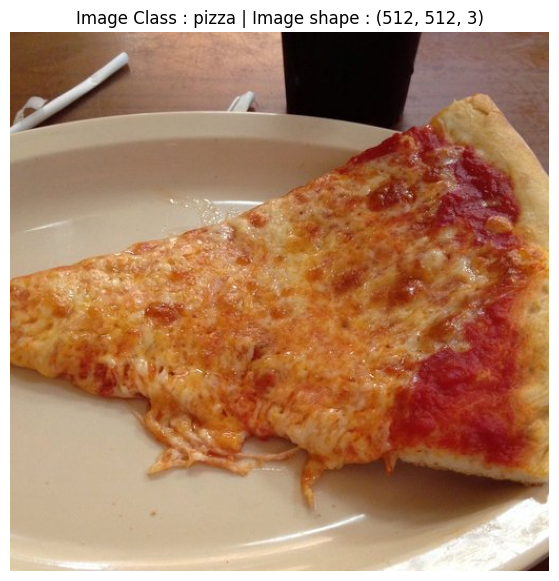

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Turn the image into an array
img_as_array = np.array(img)

#Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image Class : {image_class} | Image shape : {img_as_array.shape}")
plt.axis(False)

### 3. Transforming data

Before we can use our image data with pytoch:

1. Turn your target data into tensors
2. Turn it into a `torch.utils.Dataset`
and subsequently a `torch.utils.data.DataLoader` , we'll call these `Dataset` and `DataLoader`

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets , transforms



### 3.1 Transforming data with `torchvision.transforms`

Transform help you to get your images ready to be used with the model

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the imahes randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into tensor
    transforms.ToTensor(),
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

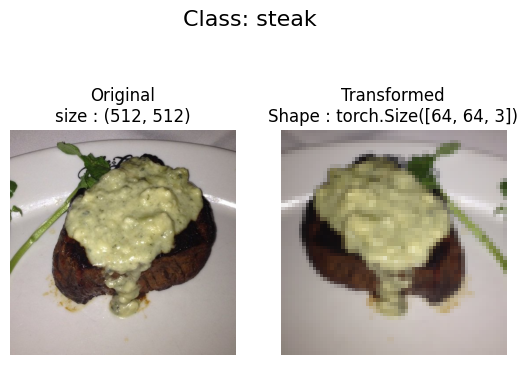

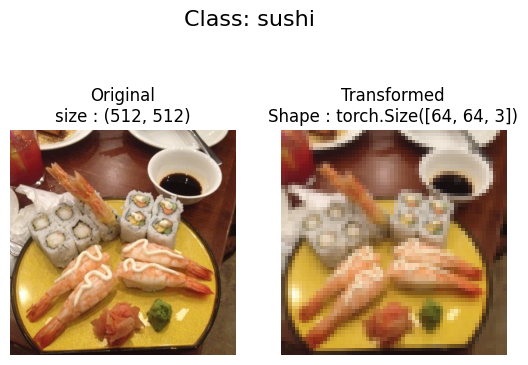

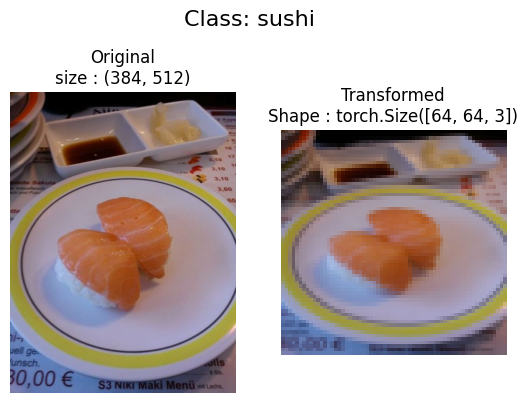

In [ ]:
def plot_transformed_images(image_path , transforms , n=3 , seed=42):
  """
  Selects random images from a path of images and load/transfor them then plot the original vs the transformed image
  """
  if seed:
    random.seed(seed)
  random_image_path = random.sample(image_path , k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig , ax  = plt.subplots(nrows=1 , ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nsize : {f.size}")
      ax[0].axis(False)

      # Transform and plot the target image
      transformed_image = transforms(f).permute(1, 2 , 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape : {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}" , fontsize=16)

plot_transformed_images(image_path=image_path_list,
                        transforms=data_transform,
                        n=3,
                        seed=42)

### 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`


In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform=data_transform,  # a transform for the data
                                  target_transform=None)  # a transform for the label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data , test_data



(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class name as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class name as a dictoniry
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the length of our data
len(train_data) , len(test_data)

(225, 75)

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
# Index on the train data datasets to get a single image and label
img , label = train_data[0][0] , train_data[0][1]
print(f"Image tensor: \n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype : {img.dtype}")
print(f"Image label: {label}")
print(f"label datatype: {type(label)}")

Image tensor: 
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.

In [ ]:
class_names[label]

'pizza'

Original shape: torch.Size([3, 64, 64])
Image permute : torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

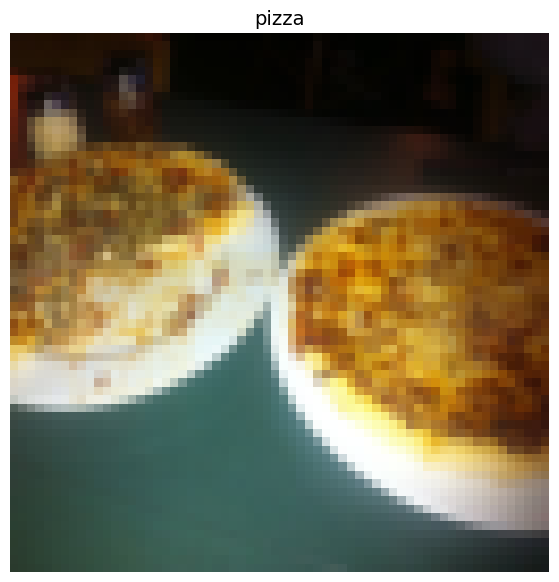

In [ ]:
# Rearrange the order of dimension
img_permute = img.permute(1, 2, 0)

#Print out diffrenet shapes
print(f"Original shape: {img.shape}")
print(f"Image permute : {img_permute.shape}")

# Plot the img
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label] , fontsize=14)

### 4.1 Turn loaded images into `DataLoader's`

A `DataLoader` is going to help us turn our `Dataset` inot iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.


In [ ]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle = False)

train_dataloader , test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c9e9cc06e70>,
 <torch.utils.data.dataloader.DataLoader at 0x7c9e9cbab2c0>)

In [ ]:
len(train_data) , len(test_data)

(225, 75)

In [ ]:
len(train_dataloader) , len(test_dataloader)

(225, 75)

In [ ]:
img , label = next(iter(train_dataloader))

# Batch size is now be 1 you can change it
print(f"Image shpae: {img.shape} -> [Batch_size , color_channels , height , width]")
print(f"laebl shape : {label.shape}")

Image shpae: torch.Size([1, 3, 64, 64]) -> [Batch_size , color_channels , height , width]
laebl shape : torch.Size([1])


### 5 Option 2 : Loading Image data with a Custom `Dataset`

1. Want to be able to load image from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classess as dictionary from the Dataset

Pros :  
* Can create a `Datset` out of almost anything
* Not limited to PyTorch pre-Build `Dataset` Fucntions

cons :
* Even though you could create `dataset` out of almost anything , it doesn't means it will work...

* Using a custom `Dataset` often results in us writting more code, which could be prone to errors or performance issues

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple , Dict , List



In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes , train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class name:
we want a function to :
1. Get the class.names using `os.scandir()`  to traverse a target directory(ideally the directory is in standard image classification formate )
2 . Raise an erro if the class name aren't found (if this happens , there might be something wrong with the directory structure ).
3 , Turn the class name into a dict and list and return them


In [ ]:
# Setup the target directory
target_directory = train_dir
print(f"Target dir : {target_directory}")

# Get the class names from the target director
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir : data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory:str) -> Tuple[List[str] , Dict[str , int]]:
  """Finds the class folder name in a target directory ."""
  # 1. Get the class names by scanning the tagert directoy
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Could't Find any classes in {directory}... PLese check file sturcture")
    # 3. Creae a dictionary of index labels
  class_to_idx  = {class_names: i for i , class_names in enumerate(classes)}
  return classes , class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Create a cusomt `Dataset` to replicate `ImageFolder`

To Create our own custom dataset , we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from ) as well as a transform if we'd like to transform our data.
3. Create severals attributes:
 * Paths - paths of our images
 * transform - the transform we'd like to use
 * classes- a list of the target classes  
 * class_to_idx - a dict of the target classes mapped to integer labels

4. Create a function to `load_images()` this function will open an image
5. Overwrite the __len()__ method to return the length of our dataset
6. Overwrite the __getitem()__ method to return a given sample when passed an index

In [ ]:
# 0. write a custom dataset class
from torch.utils.data import Dataset

# 1. subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self , targ_dir: str , transform=None):
    # 3 Cerate class attributes
    #Get all of the image path
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    #Setup the transforms
    self.transform = transform
    #Create classes or class_to_idx
    self.classes , self.class_to_idx = find_classes(targ_dir)

  # 4 Create a function to load images

  def load_image(self , index:int) -> Image.Image:
    "opens an image via a path and retuns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5 Overwrite __len__()
  def __len__(self) -> int :
    return len(self.paths)

  # Overwrite __getitem__() method to return a particular sample
  def __getitem__(self , index:int) -> Tuple[torch.Tensor , int]:
    "Return one sample of data and label X and y."
    img = self.load_image(index)
    class_names = self.paths[index].parent.name # expects path in formate
    class_idx = self.class_to_idx[class_names]

    # Transform if necessary
    if self.transform:
      return self.transform(img) , class_idx # return data label
    else:
      return img , class_idx

In [ ]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64 ,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64 ,64)),
    transforms.ToTensor()
])



In [ ]:
# Test out ImageFolderCusotm
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [ ]:
train_data_custom , test_data_custom

(<__main__.ImageFolderCustom at 0x7c9e9cc2c1d0>,
 <__main__.ImageFolderCustom at 0x7c9e9cb79430>)

In [ ]:
len(train_data) , len(train_data_custom)

(225, 225)

In [ ]:
len(test_data) , len(test_data_custom)

(75, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check for equaity between original ImageFolder Dataset and Custom Image folder
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display images

1. Take in a `Dataset` and number of other parameters such as class name and how many images

2. To prevent the display getting out of hand , lets cap the number of images to see at 10.
3. et the random seed for the reproductibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. loop through the sample images and plot them with matplotlib
7. make sure the dimensions of our images line up with matplotlib(HWC)


In [ ]:
# 1. Create a function to take in dataset
def display_random_images(dataset:torch.utils.data.Dataset,
                          classes:List[str] =None,
                          n: int = 10,
                          display_shape : bool = True,
                          seed: int = None):
  # 2.Adjust display if n is too high
  if n > 10:
    n =10
    display_shape = False
    print(f"For display , purpose , n shouldn't be larger to 10 and removing shape display. ")

    # 3 Set the seed
    if seed:
      random.seed(seed)

  # 4 Get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)) , k=n)

  # 5 setup plot
  plt.figure(figsize=(16, 8))

    # 6 Loop through the random indexes and plot them
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image , targ_label = dataset[targ_sample]

    # 7 Adjust tensors dimension for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0)


    # Plot adjusted samples
    plt.subplot(1 , n , i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class : {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"

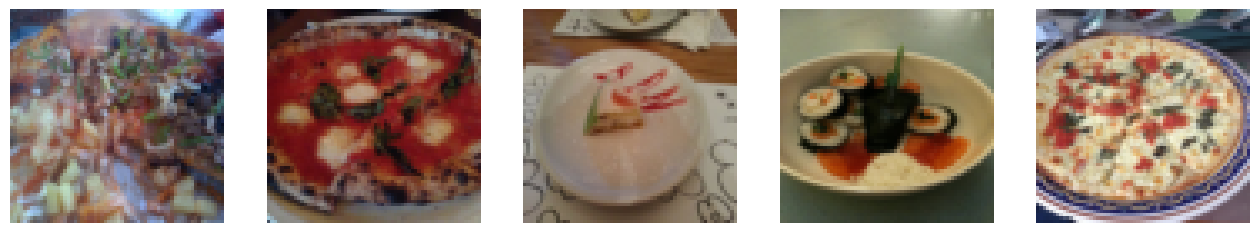

In [ ]:
# Display random image from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

In [ ]:
random.sample(range(len(train_data_custom)) , k=10)

[173, 189, 139, 22, 151, 108, 8, 7, 23, 55]

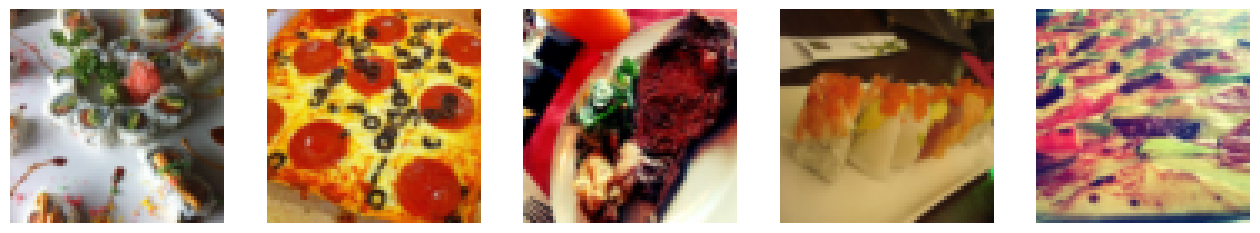

In [ ]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

In [ ]:
# Turn train and test custom  datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)
test_dataloader_custom = DataLoader(test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom , test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7c9e9ca1a8a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c9e9cb79190>)

In [ ]:
# Get image and label from the custom dataloader

img_custom , label_custom =  next(iter(train_dataloader_custom))

img_custom.shape , label_custom.shape


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### 6. Other forms of transfor (data augmentation)
# Data augmentation is the process of artificially adding diversity to your training data

Let's take a look one paticular type of data augmentation used to train PyTorch vision models to state of art levels...




In [ ]:
# Let's look at Trivialaugment

from torchvision import transforms


train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 244)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # parameter -> how intense you want the augmentation
    transforms.ToTensor()
])

test_transforms = transforms.Compose([transforms.Resize(size=(224 , 224)),
                                      transforms.ToTensor])



In [ ]:
# Get all images paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/343036.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/207578.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2715127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/684266.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1680893.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2741434.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2521706.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/988559.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/719108.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/175783.jpg')]

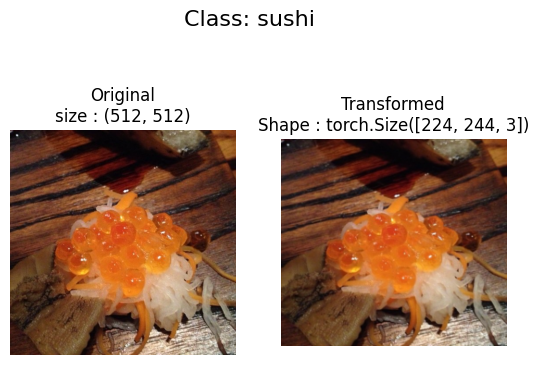

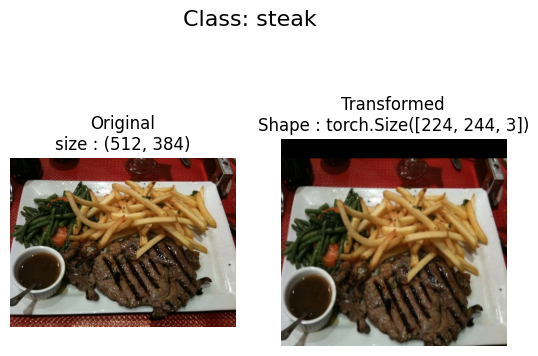

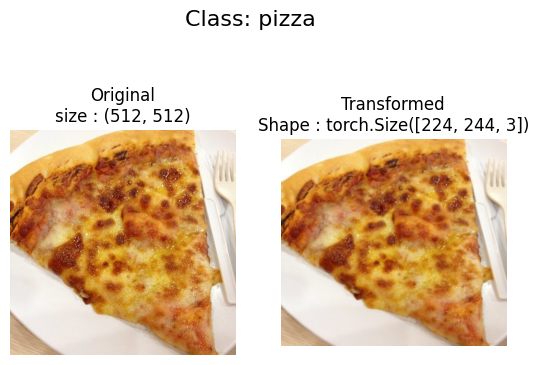

In [ ]:
# Plot random transformed images
plot_transformed_images(
    image_path=image_path_list,
    transforms=train_transforms,
    n=3,
    seed=None
)

### 7 Model 0 : TinyVGG withoud data augmentation

Lets replicate TinyVGG architecture from the CNN explainer web

### 7.1 Creating transforms and loading data for model 0


In [ ]:
# Create simple transform
simple_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                       transforms.ToTensor()])



In [ ]:
# load and transform the data
from torchvision import datasets
train_data_simple =  datasets.ImageFolder(root=train_dir,
                                          transform=simple_transform)
test_data_simple =  datasets.ImageFolder(root=test_dir,
                                          transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setu batchsize and num_workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

#Create a dataloader
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size= BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size= BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

### 7.2 Create TinyVGG model class


In [ ]:
class TinyVGG(nn.Module):
  def __init__(self , input_shape:int,
               hidden_units:int,
               output_shape:int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=3,
        stride=1,
        padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)  # defalut stride value is same as kernel size
    )
      self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=3,
        stride=1,
        padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)  # defalut stride value is same as kernel size
    )

      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)

      )
  def forward(self , x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x)))



In [ ]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3, # number of color channels
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.4 Try a forward pass on a single image

In [ ]:
# Get a single image batch

image_batch , label_batch = next(iter(train_dataloader_simple))
image_batch.shape , label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### 7.5 Use `torchinfo ` to get an idea of the shapes going through our model

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0 , input_size=[1, 3, 64 , 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.6 Create train and test loops functions

* `train_Step()` - takes in a model and dataloader and trains the model on the dataloader
* `test__step()` - takes in a model and dataloader and evaluate the model and the dataloader


In [ ]:
# Create a train_step()

def train_step(model: torch.nn.Module,
               dataloader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode

  model.train()

  # Setup train loss and train accuracy values
  train_loss , train_acc = 0 , 0

  # Loop through data loader data batches
  for batch , (X , y) in enumerate(dataloader):
    # Send data to target device
    X , y  = X.to(device) , y.to(device)

    # 1 Forward pass
    y_pred = model(X)

    # 2 Calculate the loss

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3 Optimizer zero grad
    optimizer.zero_grad()

    # 4 loss backward
    loss.backward()

    # 5 optimizer step
    optimizer.step()

    # Calculate the accuracy metrics
    y_pred_class = torch.argmax(torch.softmax(y_pred , dim=1) , dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust the metrics to get the average loss and accuracy evry batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc



In [ ]:
# Create a test step function
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              device=device):
  # Put the model on test mode
  model.eval()

  # Setup test_loss and test_acc values
  test_loss , test_acc = 0 , 0

  # Turn on inference mode
  with torch.inference_mode():

    # Loop through the dataloader per batch
    for batch, (X ,y) in enumerate(dataloader):
      #Send the data to the target device
      X , y  = X.to(device) , y.to(device)

      # 1 forward pass
      test_pred_logits = model(X)

      # 2 Claculate the loss
      loss = loss_fn(test_pred_logits , y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels== y).sum().item()/len(test_pred_labels))


  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss , test_acc


In [ ]:
from tqdm.auto import tqdm
def train(model:torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss,
          epochs: int = 5,
          device=device):

  results = {"train_loss" : [],
             "train_acc" : [],
             "test_loss" : [],
             "test_acc" : []}

  for epoch in tqdm(range(epochs)):
    train_loss , train_acc = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device)
    test_loss , test_acc = test_step(model=model,
                                     dataloader=test_dataloader,
                                     loss_fn=loss_fn,
                                     device=device)

    print(f"Epoch : {epoch} | Train loss : {train_loss:.4f} | train acc : {train_acc:.4f}% | Test loss : {test_loss:.4f} | test acc : {test_acc:.4f}%")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results


### 7.7 Train and evaluate the model_0

In [ ]:
# Set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Set number of epochs
NUM_EPOCHS = 5

# Recarate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)


# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device=device,
                        epochs=NUM_EPOCHS)


# End the timer
end_time = timer()
print(f"Total training time : {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 0 | Train loss : 1.1063 | train acc : 0.3047% | Test loss : 1.0983 | test acc : 0.3011%
Epoch : 1 | Train loss : 1.0998 | train acc : 0.3281% | Test loss : 1.0697 | test acc : 0.5417%
Epoch : 2 | Train loss : 1.0869 | train acc : 0.4883% | Test loss : 1.0808 | test acc : 0.4924%
Epoch : 3 | Train loss : 1.0846 | train acc : 0.4023% | Test loss : 1.0606 | test acc : 0.5729%
Epoch : 4 | Train loss : 1.0664 | train acc : 0.4180% | Test loss : 1.0660 | test acc : 0.5644%
Total training time : 6.630 seconds


### 7.8 Plot the loss curves of model 0

A **loss curv** is a way of tracking your loss over time

In [ ]:
# Get the model 0 results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str , List[float]]):
  # get the loss values of results dic
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  # setup the plot
  plt.figure(figsize=(15 , 7))

  # plot the loss
  plt.subplot(1, 2 ,1)
  plt.plot(epochs , loss , label="Train_loss")
  plt.plot(epochs , test_loss , label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # PLot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs , accuracy , label="train_accuracy")
  plt.plot(epochs , test_acc , label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

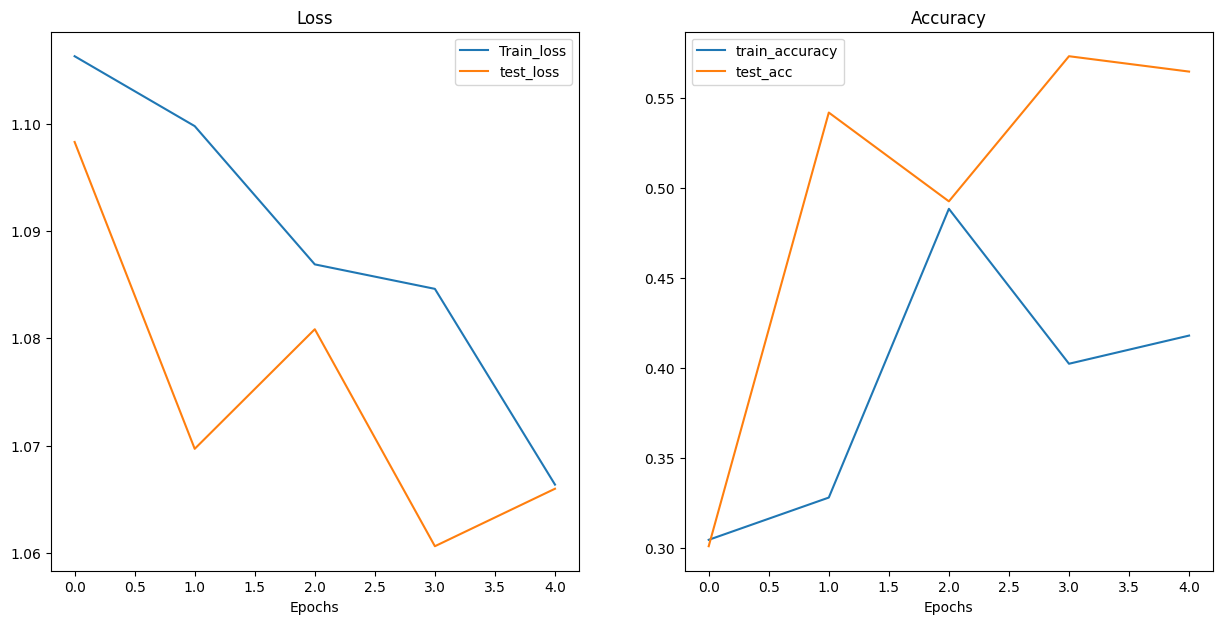

In [ ]:
plot_loss_curves(model_0_results)

### 8. What should an ideal loss curve look like ?

A loss curve is one of the most helpful way to trubleshoot a model performance

### 9 Model 1. TinyVGG with Data Augmentation

Now lets try another modelling experiment
this time using the same model as before but  with some data augmentation

### 9.1 Create transform with data augmentaion

In [ ]:
# Create training transform with TrivialAugmnet
from torchvision import transforms
train_transform_trivial  = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple  = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_transform_trivial , test_transform_simple

(Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [ ]:
# Turn the image folder into datasets

from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [ ]:
# Turn the Datasets into Dataloader
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32

NUM_WORKERS = os.cpu_count()


torch.manual_seed(42)

train_dataloader_augmented  = DataLoader(dataset=train_data_augmented,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         shuffle=True)

test_dataloader_simple  = DataLoader(dataset=test_data_simple,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         shuffle=False)


### 9.3 Construct and train model 1

This time we'lll be using the  same model architechture except this time we've aumented the training data

In [ ]:
#Creat model 1 and send it to the target device

torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Wonderfull Now we've a model and dataloaders , lets create a loss function and an optimizer and call  upon the train() function to train and evaluate

In [ ]:
# Set up the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup the loss function

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer
end_time = timer()

print(f"Total training time for model_1 : {end_time - start_time:.3f} seconds ")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 0 | Train loss : 1.1049 | train acc : 0.2500% | Test loss : 1.1019 | test acc : 0.2604%
Epoch : 1 | Train loss : 1.0807 | train acc : 0.4258% | Test loss : 1.1261 | test acc : 0.2604%
Epoch : 2 | Train loss : 1.0712 | train acc : 0.4258% | Test loss : 1.1592 | test acc : 0.2604%
Epoch : 3 | Train loss : 1.1254 | train acc : 0.3047% | Test loss : 1.1581 | test acc : 0.2604%
Epoch : 4 | Train loss : 1.0859 | train acc : 0.4258% | Test loss : 1.1552 | test acc : 0.3333%
Total training time for model_1 : 5.138 seconds 


### 9.4 Evaluate the model - plot the loss curves

In [ ]:
# Get the model 0 results keys
model_1_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

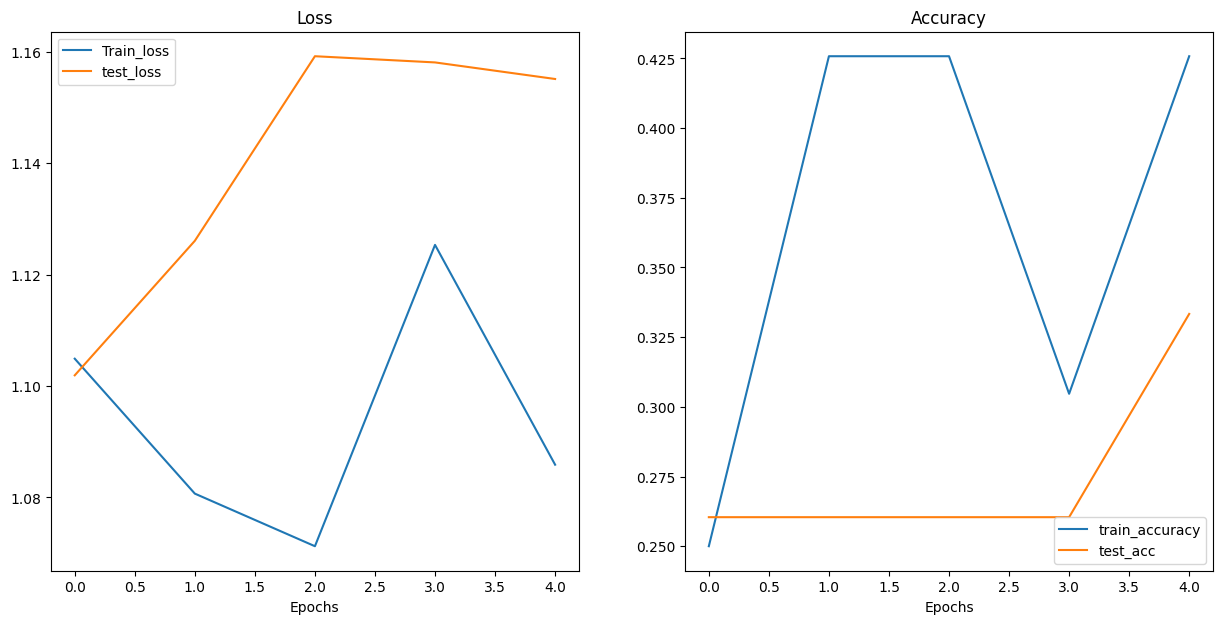

In [ ]:
plot_loss_curves(model_1_results)

### 10. Comapre the model results

After evaluating our modelling experiment on there own , it's important to compare them to each other.

There's a few different ways of doing comparisiom :

* Hard coding
* PyTorch + tensorboard
* Weight and Baises
* MLFlow

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099799,0.328125,1.069692,0.541667
2,1.086899,0.488281,1.080849,0.492424
3,1.084616,0.402344,1.060605,0.572917
4,1.066354,0.417969,1.065968,0.564394


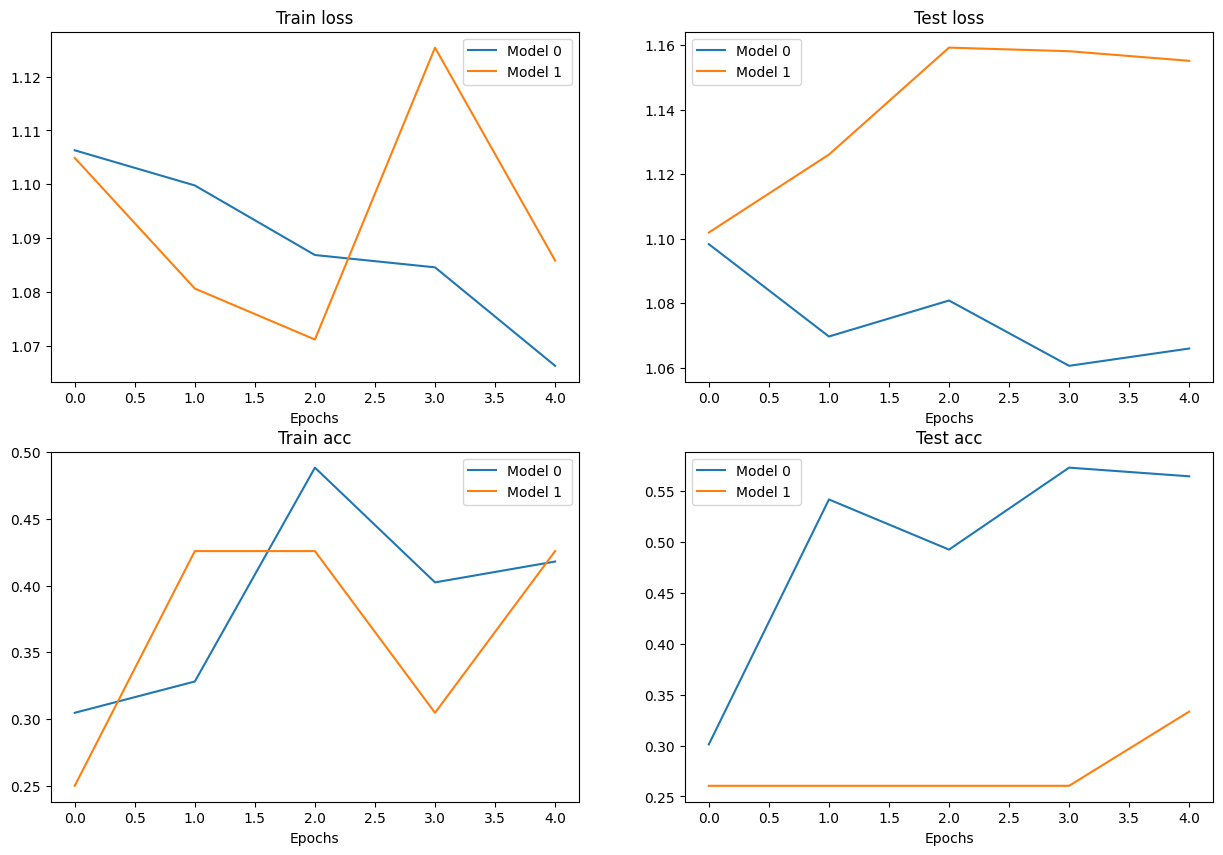

In [ ]:
# Set up a plot
plt.figure(figsize=(15 , 10))

epochs = range(len(model_0_df))

# plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs , model_0_df["train_loss"] , label="Model 0 ")
plt.plot(epochs , model_1_df["train_loss"] , label="Model 1 ")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

# plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs , model_0_df["test_loss"] , label="Model 0 ")
plt.plot(epochs , model_1_df["test_loss"] , label="Model 1 ")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()


# plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs , model_0_df["train_acc"] , label="Model 0 ")
plt.plot(epochs , model_1_df["train_acc"] , label="Model 1 ")
plt.title("Train acc")
plt.xlabel("Epochs")
plt.legend()

# plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs , model_0_df["test_acc"] , label="Model 0 ")
plt.plot(epochs , model_1_df["test_acc"] , label="Model 1 ")
plt.title("Test acc")
plt.xlabel("Epochs")
plt.legend()

### 11.  Making a prediction on a custom image

Although we've trained a model on custom data... How do you make a prediction on a sampe/image that's not either in training and testing


In [ ]:
# Download custom image
import requests

# Setup custom image path

custom_image_path = data_path / "04-pizza-dad.eg"

#Download the image if it doesn't already exists
if not custom_image_path.is_file():
  with open(custom_image_path , "wb") as f:
    # Whne downloading from the github , need to use "raw" file link
    res = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/04-pizza-dad.jpeg")
    print(f"Downloading .. {custom_image_path}")
    f.write(res.content)

else:
  print(f"{custom_image_path} already exist skipping downloading")

### 11.1 Loading in a custom image with pytorch

we have to make sure our custom image is in same formate as the data our madel was trained on

* In tensor form with datatype(torch.float32)
* Of shape 64x64x3
* On the right device

We can read an image into Pytorch using - ImageReadMode

In [ ]:
import torchvision
# Read in custom image

custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))


print(f"Custom image tensor:\n {custom_image_unit8}")
print(f"Custom image shape: {custom_image_unit8.shape}")
print(f"Custom image datatype : {custom_image_unit8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

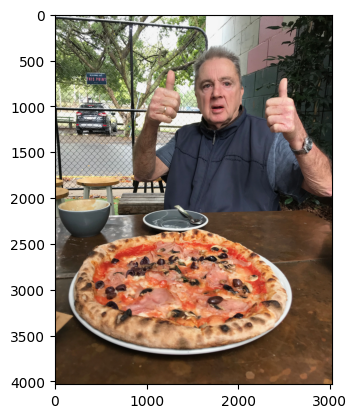

In [ ]:
plt.imshow(custom_image_unit8.permute(1, 2, 0))

##11.2 Makig a prediction o a custom image with a trained pytorch model


In [ ]:
# Loading in the custom imae and convert it in to float 32
custom_image  = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255

custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [ ]:
# Try to make a prediction on an image unit8 formate

model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [ ]:
# Create tranasform pipeline to resize the image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print the shapes
print(f"Original shapes : {custom_image.shape}")
print(f"Transformed shape : {custom_image_transformed.shape}")



Original shapes : torch.Size([3, 4032, 3024])
Transformed shape : torch.Size([3, 64, 64])


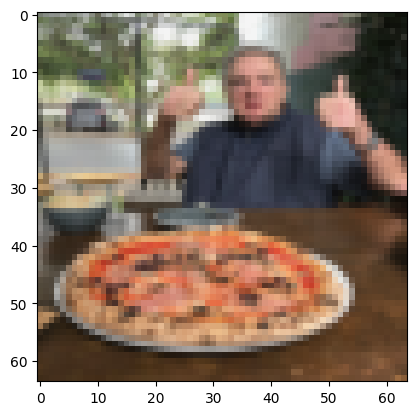

In [ ]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [ ]:
# This will error - No batch size
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [ ]:
custom_image_transformed.shape , custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0796,  0.0361, -0.2084]], device='cuda:0')

Note: To make a prediction on a custom image we has to:
*  Load the image and turn in the tensor
* make sure the image is in the same datatype
* make sure the image is on the same device

In [ ]:
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# convert logits -> pred prob
custom_image_pred_probs = torch.softmax(custom_image_pred , dim=1)
custom_image_pred_probs

tensor([[0.3694, 0.3537, 0.2770]], device='cuda:0')

In [ ]:
# convert pred prob -> pred labels

custom_image_pred_labels = torch.argmax(custom_image_pred_probs  , dim=1)
custom_image_pred_labels

tensor([0], device='cuda:0')

In [ ]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 Putting custom image prediction togher : Building a function

ideal outcome:
A function where we pass as image path to and have our model predict on that image and plot the image + preduction

In [ ]:
def pred_and_plot_img(model:torch.nn.Module,
                      image_path:str,
                      class_names:List[str] = None,
                      transform=None,
                      device=device):
  """Make a prediction in a target image witht a trained model and plots the image and prediction """
  # Load the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Devide the image pizel values by 255 to get them between [0 ,1]
  target_image = target_image / 255

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # make sure the model is on target device
  model.to(device)

  # Turn on evsl mode and make prediction
  model.eval()
  with torch.inference_mode():
    target_image  = target_image.unsqueeze(0)

    # make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device))

  # Covert the logits to pred prob
  target_image_pred_porbs = torch.softmax(target_image_pred , dim=1)

  # Convert the pred probs -> pred labels
  target_image_pred_label = torch.argmax(target_image_pred_porbs , dim=1)

  # Plot the image along side the prediction and prediction probabilities
  plt.imshow(target_image.squeeze().permute(1 ,2, 0))  # remove batch dimension and rearrange shape to be HWC
  if class_names:
    title  = f"Pred : {class_names[target_image_pred_label.cpu()]} | Prob : {target_image_pred_porbs.max().cpu():.3f}"
  else:
    title = f"Pred : {target_image_pred_label} | Prob : {target_image_pred_porbs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)


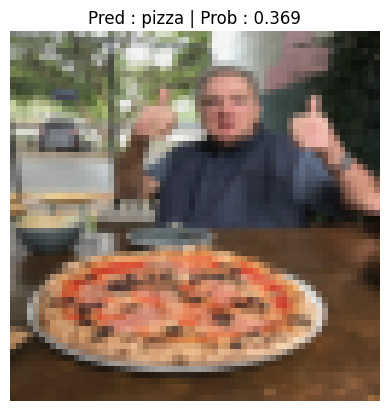

In [ ]:
# Pre on our custom image
pred_and_plot_img(model=model_1,
                  image_path=custom_image_path,
                  class_names=class_names,
                  transform=custom_image_transform,
                  device=device)